In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow
! pip install keras
! pip install git+https://www.github.com/keras-team/keras-contrib.git
#! pip install seqeval

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-l5ow_aob
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-l5ow_aob
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras_contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101058 sha256=6c83ef74f5aafe669e6a2bc65cd30a4511388b8aad848fe49739c2d03c37ea16
  Stored in directory: /tmp/pip-ephem-wheel-cache-vy33_mwa/wheels/51/5f/dc/dade7fdf81085b847dde4bd2fa307f2e0f67a26400031d0c27
Successfully built keras_contrib


In [ ]:
!pip install sklearn-crfsuite
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BAHAN SKRIPSI/data/ner_dataset.csv')
df.head(20)

,Sentence #,Word,POS,Tag
0,1,Dinkes,NNP,ORG
1,1,Mataram,NNP,ORG
2,1,minta,VB,O
3,1,warga,NN,O
4,1,terapkan,VB,O
5,1,PHBS,NN,O
6,1,antisipasi,NN,O
7,1,cacar,JJ,O
8,1,monyet,NN,O
9,2,Sudah,MD,O


In [ ]:
df = df[df['Tag'] != 'O']

df = df.reset_index(drop=True)

print(df)

      Sentence #           Word  POS  Tag
0              1         Dinkes  NNP  ORG
1              1        Mataram  NNP  ORG
2              2     Bangladesh  NNP  LOC
3              3         Dinkes  NNP  ORG
4              3           Biak  NNP  ORG
...          ...            ...  ...  ...
2073        1149  Cianjur-Jabar  NNP  LOC
2074        1150           IDAI  NNP  ORG
2075        1151       Kemenkes  NNP  ORG
2076        1152         Malang  NNP  LOC
2077        1153        Nganjuk   FW  LOC

[2078 rows x 4 columns]


In [ ]:
# Assuming your DataFrame is called 'df'
unique_tags = df['Tag'].unique()

# Print the unique tags
print(unique_tags)

['ORG' 'LOC' 'PER']


In [ ]:
df.nunique()

,0
Sentence #,1153
Word,961
POS,12
Tag,3


In [ ]:
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        #self.grouped = self.df.groupby("Sentence #", group_keys=False).apply(agg)
        self.sentences = [s for s in self.grouped]

    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [ ]:
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[1]


<ipython-input-9-eb3803782f17>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.df.groupby("Sentence #").apply(agg)


'Bangladesh'

In [ ]:
class SentenceGetter:
    def __init__(self, df):
        self.df = df
        self.sentences = self.get_sentences()

    def get_sentences(self):
        # Misalkan ini mengubah DataFrame menjadi list of sentences
        sentences = []
        for _, group in self.df.groupby("Sentence #"):
            sentence = list(zip(group["Word"], group["POS"], group["Tag"]))
            sentences.append(sentence)
        return sentences

    def get_text(self):
        # Mengambil kalimat pertama atau semua kalimat
        return self.sentences  # Pastikan mengembalikan sesuatu selain None


In [ ]:
getter = SentenceGetter(df)
sent = getter.get_text()  # Pastikan ini tidak menghasilkan None
print(sent)


[[('Dinkes', 'NNP', 'ORG'), ('Mataram', 'NNP', 'ORG')], [('Bangladesh', 'NNP', 'LOC')], [('Dinkes', 'NNP', 'ORG'), ('Biak', 'NNP', 'ORG')], [('Pemprov', 'NNP', 'ORG'), ('DKI', 'NNP', 'ORG')], [('Dinkes', 'NNP', 'ORG'), ('Lombok', 'NNP', 'LOC'), ('Tengah', 'NNP', 'LOC')], [('Jakbar', 'NN', 'LOC')], [('Jakarta', 'NNP', 'LOC'), ('Selatan', 'NNP', 'LOC')], [('Dinkes', 'NNP', 'ORG'), ('Kepri', 'NNP', 'ORG')], [('Kadinkes', 'NNP', 'PER'), ('Batam', 'NNP', 'LOC')], [('BRIN', 'NNP', 'ORG')], [('BRIN', 'NNP', 'ORG'), ('Indonesia', 'NNP', 'LOC')], [('Kemenkes', 'NNP', 'ORG')], [('Kemenkes', 'NNP', 'ORG')], [('Jawa', 'NNP', 'LOC'), ('Barat', 'NNP', 'LOC')], [('RS', 'NNP', 'ORG'), ('Waled', 'NNP', 'ORG'), ('Cirebon', 'NNP', 'ORG')], [('Pemkot', 'NNP', 'ORG'), ('Bandung', 'NNP', 'LOC')], [('Menkes', 'NNP', 'PER')], [('Israel', 'NNP', 'LOC')], [('DKI', 'NNP', 'LOC')], [('Sudinkes', 'NNP', 'ORG'), ('Jakpus', 'NNP', 'LOC')], [('Tangerang', 'NNP', 'LOC'), ('Selatan', 'NNP', 'LOC')], [('DKI', 'NNP', 'LO

In [ ]:


# Ambil tag yang unik dan terurut
#tags = list(df['Tag'].unique())
#words = list(df['Word'].unique())


#word_to_index = {w : i + 2 for i, w in enumerate(words)}
#word_to_index["UNK"] = 1
#word_to_index["PAD"] = 0


#tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
#tag_to_index["PAD"] = 0

#idx2word = {i: w for w, i in word_to_index.items()}
#idx2tag = {i: w for w, i in tag_to_index.items()}


# Tentukan urutan tag manual agar konsisten
tags = [ 'ORG', 'PER', 'LOC']
words = list(df['Word'].unique())

# Buat kamus kata ke indeks
word_to_index = {w: i + 2 for i, w in enumerate(words)}  # +2 karena 0 = PAD, 1 = UNK
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Buat kamus tag ke indeks
tag_to_index = {tag: i for i, tag in enumerate(tags)}  # {'O': 0, 'ORG': 1, 'PER': 2, 'LOC': 3}
tag_to_index["PAD"] = len(tag_to_index)  # Tambahkan PAD sebagai label khusus padding (misal: 4)

# Mapping sebaliknya
idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: t for t, i in tag_to_index.items()}


In [ ]:
print("Tag to index:", tag_to_index)
print("Index to tag:", idx2tag)

Tag to index: {'ORG': 0, 'PER': 1, 'LOC': 2, 'PAD': 3}
Index to tag: {0: 'ORG', 1: 'PER', 2: 'LOC', 3: 'PAD'}


In [ ]:
seqs_length = [len(s) for s in sentences]
max_seq_length = max(seqs_length)
print(f"Max sequence length: {max_seq_length}")

num_words = len(words)
print(f"Number of words: {num_words}")

num_tags = len(tags)
print(f"Number of tags: {num_tags}")

Max sequence length: 7
Number of words: 961
Number of tags: 3


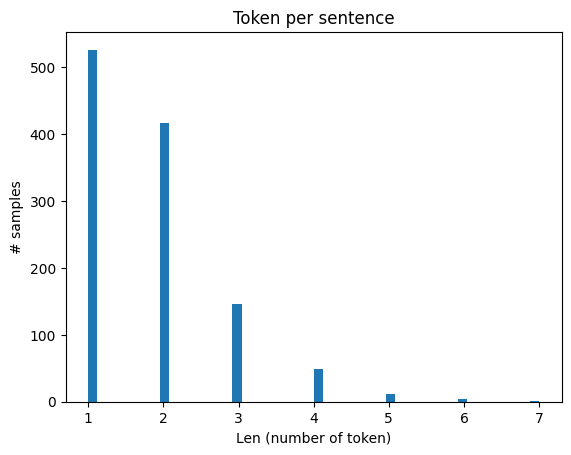

In [ ]:
import matplotlib.pyplot as plt

# Get all the sentences
sentences = getter.sentences
# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
sentences = getter.sentences

In [ ]:
X = [[word_to_index[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_seq_length, sequences = X, padding = "post", value = word_to_index["PAD"])

In [ ]:
y = [[tag_to_index[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_seq_length, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [ ]:
y = [to_categorical(i, num_classes = num_tags + 1) for i in y]

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=1)

In [ ]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (1037, 7)
Size of training output data :  (1037, 7, 4)
Size of testing input data :  (116, 7)
Size of testing output data :  (116, 7, 4)


In [ ]:
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

_input = Input(shape=(max_seq_length,))
_embed = Embedding(input_dim=num_words + 2, output_dim = max_seq_length, input_length=max_seq_length)(_input)
_embed = Dropout(0.2)(_embed)
_arch = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(_embed)
_output = TimeDistributed(Dense(num_tags + 1, activation="softmax"))(_arch)  # softmax output layer

model = Model(_input, _output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 7, 7)           │         6,741 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 7, 256)         │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 7, 4)           │         1,028 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,033 (574.35 KB)

 Trainable params: 147,033 (574.35 KB)

 Non-trainable params: 0 (0.00 B)

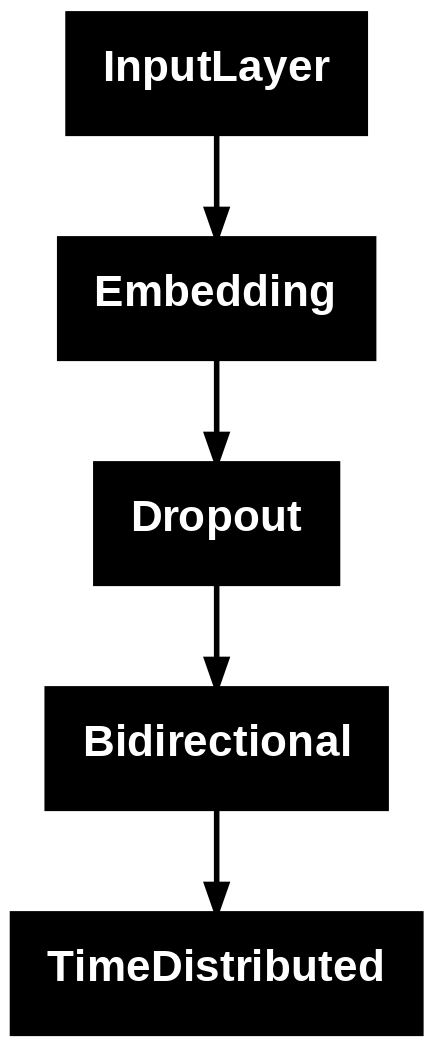

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2,verbose = 1,mode = 'min',restore_best_weights = True)

checkpointer = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/BAHAN SKRIPSI/hasil/model-{val_accuracy:.2f}.keras', # Changed .hdf5 to .keras
    verbose = 1,
    mode = 'min',
    save_best_only = True,
    monitor='val_loss')

# callbacks = [checkpointer]

history = model.fit(
    X_train,np.array(y_train),
    validation_split =0.1,
    batch_size = 16,
    epochs = 20,
    callbacks = [checkpointer]
)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7198 - loss: 1.0159
Epoch 1: val_loss improved from inf to 0.40363, saving model to /content/drive/MyDrive/BAHAN SKRIPSI/hasil/model-0.83.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7205 - loss: 1.0110 - val_accuracy: 0.8338 - val_loss: 0.4036
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8270 - loss: 0.4025
Epoch 2: val_loss improved from 0.40363 to 0.29637, saving model to /content/drive/MyDrive/BAHAN SKRIPSI/hasil/model-0.85.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8271 - loss: 0.4018 - val_accuracy: 0.8530 - val_loss: 0.2964
Epoch 3/20
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8511 - loss: 0.3078
Epoch 3: val_loss improved from 0.29637 to 0.27636, saving model to /content/drive/MyDrive/BAHAN SKRIPSI/hasil/model-0.85.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8513 - loss: 0.3074 - val_accuracy: 0.8462 - val_loss: 0.2764
Epoch 4/20
59/59

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/BAHAN SKRIPSI/hasil/model-0.91.keras')

In [ ]:
model.evaluate(X_test,np.array(y_test))
loss, accuracy = model.evaluate(X_test,np.array(y_test), verbose=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9048 - loss: 0.2306


In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 740ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


In [ ]:
!pip install plot-keras-history

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

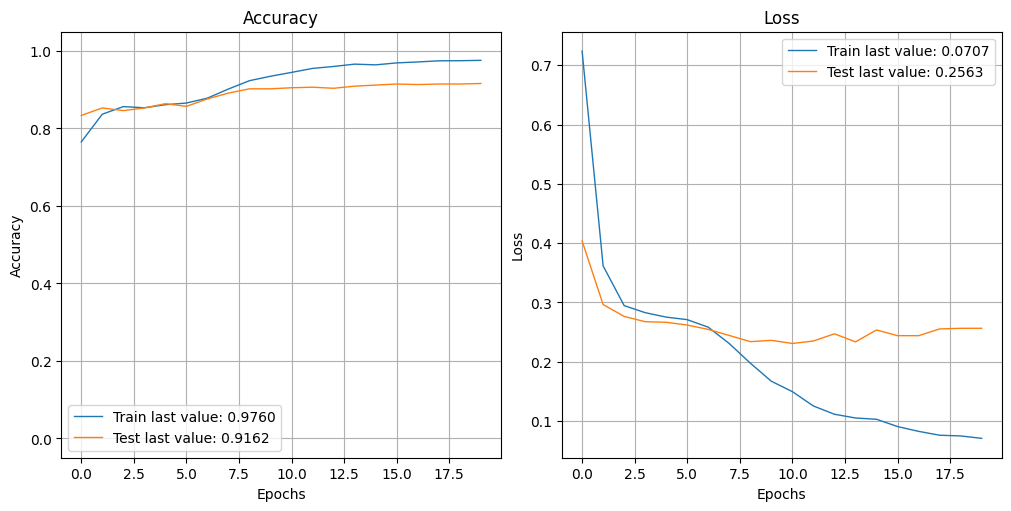

In [ ]:
from plot_keras_history import plot_history

plot_history(history.history)

In [ ]:
y_test_true = np.argmax(y_test, -1)

In [ ]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

# Konversi prediksi dan ground truth dari indeks ke tag label
#y_pred_tags = [[idx2tag.get(i, 'UNK') for i in row] for row in y_pred]
#y_test_tags = [[idx2tag.get(i, 'UNK') for i in row] for row in y_test_true]

In [ ]:
#print(y_pred)
print(y_pred)

[['ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'PER', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'PER', 'ORG', 'PAD', 'PAD', 'PAD'], ['PER', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'PER', 'PER', 'LOC', 'PAD', 'PAD'], ['PER', 'PER', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PAD', 'PAD', 'PAD', '

In [ ]:
print(y_test_true)

[['LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PER', 'ORG', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'PER', 'PER', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'LOC', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'PER', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['PER', 'PER', 'PER', 'PER', 'PER', 'PAD', 'PAD'], ['PER', 'PER', 'ORG', 'PAD', 'PAD', 'PAD', 'PAD'], ['ORG', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'], ['LOC', 'PAD', 'PAD', 'PAD', '

In [ ]:
# prompt: make a clasification report not a seveqal

from sklearn.metrics import classification_report

print(classification_report(list(chain.from_iterable(y_test_true)), list(chain.from_iterable(y_pred))))


              precision    recall  f1-score   support

         LOC       0.66      0.72      0.69        83
         ORG       0.56      0.56      0.56        62
         PAD       1.00      1.00      1.00       606
         PER       0.70      0.61      0.65        61

    accuracy                           0.91       812
   macro avg       0.73      0.72      0.73       812
weighted avg       0.91      0.91      0.91       812



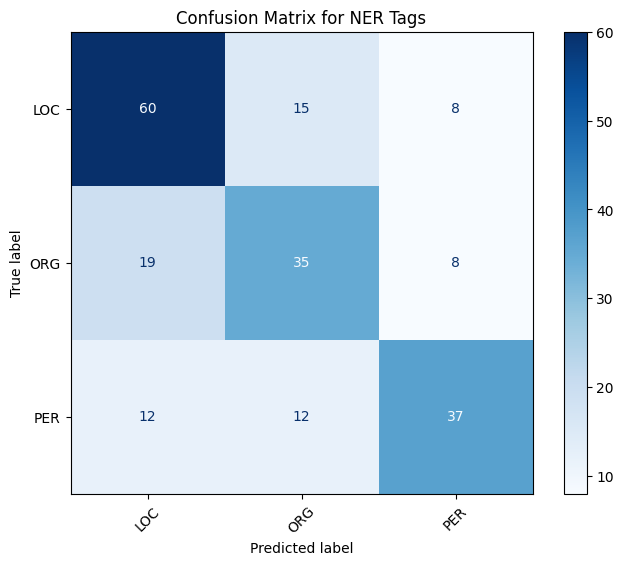

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from itertools import chain
import matplotlib.pyplot as plt

# Flatten the nested lists
flat_true = list(chain.from_iterable(y_test_true))
flat_pred = list(chain.from_iterable(y_pred))

# Dapatkan semua label unik dari data (tanpa 'PAD' jika tidak relevan)
labels = sorted(list(set(flat_true + flat_pred)))
if 'PAD' in labels:  # Optional: buang 'PAD' jika tidak dianggap kelas
    labels.remove('PAD')

# Confusion matrix
cm = confusion_matrix(flat_true, flat_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for NER Tags")
plt.show()


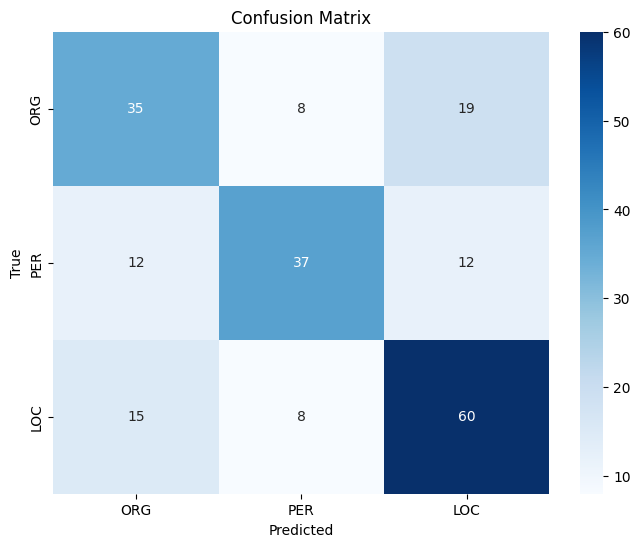

In [ ]:
# prompt: make a confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test_true and y_pred are already defined as in your code
# Calculate the confusion matrix
cm = confusion_matrix(list(chain.from_iterable(y_test_true)), list(chain.from_iterable(y_pred)), labels=tags)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tags, yticklabels=tags)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


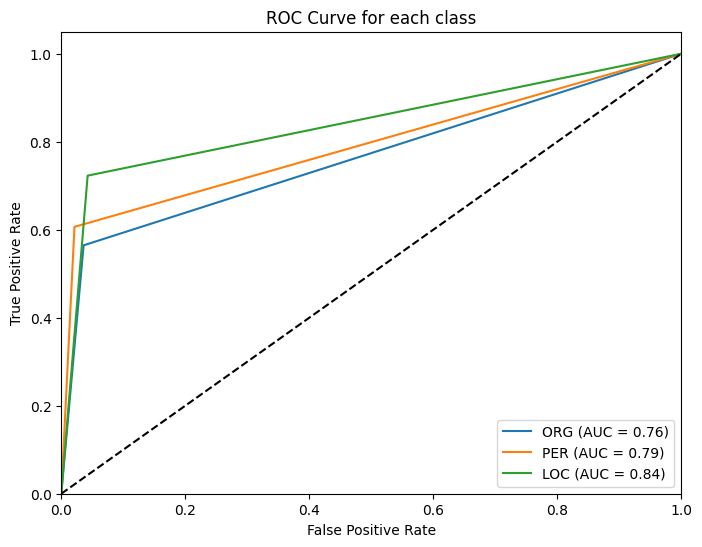

In [ ]:
# prompt: make roc auc for loc, per, org grafik

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output labels
y_test_bin = label_binarize(list(chain.from_iterable(y_test_true)), classes=tags)
y_pred_bin = label_binarize(list(chain.from_iterable(y_pred)), classes=tags)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(tags)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(tags)):
    plt.plot(fpr[i], tpr[i], label=f'{tags[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import f1_score # Import the f1_score function from sklearn.metrics

print("F1-score: {:.1%}".format(f1_score(list(chain.from_iterable(y_test_true)), list(chain.from_iterable(y_pred)), average='weighted'))) # Calculate and print the F1-score using the imported function

F1-score: 90.9%


In [ ]:
i = np.random.randint(0,X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))

print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
  if w != 0:
    if words[w-2] != "predicting":
      print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sample number 25 of 116 (Test Set)
Word           ||True ||Pred
Bio            : ORG   ORG
Farma          : ORG   ORG


In [ ]:
print("Unique tags in y_test_true:", set(tag for seq in y_test_true for tag in seq))
print("Unique tags in y_pred:", set(tag for seq in y_pred for tag in seq))

Unique tags in y_test_true: {'ORG', 'PER', 'PAD', 'LOC'}
Unique tags in y_pred: {'ORG', 'PER', 'PAD', 'LOC'}


In [ ]:
print(tag_to_index)

{'ORG': 0, 'PER': 1, 'LOC': 2, 'PAD': 3}
